In [1]:
import pandas as pd
import os 
import subprocess
import warnings 
from src.files import XMLFile, FASTAFile, GBFFFile
from src import get_genome_id
import src 
from src.dataset import Dataset
from utils import * 
from src.genome import ReferenceGenome
from src.tools import NCBIDatasets, Prodigal, MMseqs
import glob
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.gridspec import GridSpec
import dataframe_image as dfi
from sklearn.model_selection import train_test_split
from src.classifier import Classifier
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression, LinearRegression
import pingouin

%load_ext autoreload 
%autoreload 2

In [ ]:
def apply_line_settings(ax:plt.Axes):
    settings = dict()
    settings['false positive'] = {'color':'tab:red'}
    settings['true positive'] = {'color':'tab:green'}
    settings['false negative'] = {'color':'tab:red', 'ls':'--'}
    settings['true negative'] = {'color':'tab:green', 'ls':'--'}

    for line in ax.lines:
        if line.get_label() in settings:
            line.set(**settings[line.get_label()])


def apply_patch_settings(ax:plt.Axes):
    settings = dict()
    settings['false positive'] = {'color':'tab:red', 'edgecolor':'black'}
    settings['true positive'] = {'color':'tab:green', 'edgecolor':'black'}
    settings['false negative'] = {'color':'tab:red', 'hatch':'///', 'edgecolor':'black'}
    settings['true negative'] = {'color':'tab:green', 'hatch':'///', 'edgecolor':'black'}

    curr_label = '_nolegend_'
    for patch in ax.patches:
        if (patch.get_label() == '_nolegend_') and (curr_label != '_nolegend_'):
            patch.set(**settings[curr_label])
        elif patch.get_label() in settings:
            curr_label = patch.get_label()
            patch.set(**settings[curr_label])
            

In [ ]:

# ! predict --input-path ../data/filter_dataset_test.h5 --model-name filter_o1 --feature-type esm_650m_gap --output-dir ../data/predict.out --models-dir ../models --load-labels
# ! predict --input-path ../data/filter_dataset_test.h5 --model-name filter_o2 --feature-type esm_650m_gap --output-dir ../data/predict.out --models-dir ../models --load-labels
# ! predict --input-path ../data/filter_dataset_test.h5 --model-name filter_o3 --feature-type esm_650m_gap --output-dir ../data/predict.out --models-dir ../models --load-labels

# ! predict --input-path ../data/filter_dataset_test.h5 --model-name filter_e1 --feature-type esm_3b_gap --output-dir ../data/predict.out --models-dir ../models --load-labels
# ! predict --input-path ../data/filter_dataset_test.h5 --model-name filter_e2 --feature-type esm_3b_gap --output-dir ../data/predict.out --models-dir ../models --load-labels
# ! predict --input-path ../data/filter_dataset_test.h5 --model-name filter_e3 --feature-type esm_3b_gap --output-dir ../data/predict.out --models-dir ../models --load-labels 

# ! predict --input-path ../data/filter_dataset_test.h5 --model-name filter_p1 --feature-type pt5_3b_gap --output-dir ../data/predict.out --models-dir ../models --load-labels 
# ! predict --input-path ../data/filter_dataset_test.h5 --model-name filter_p2 --feature-type pt5_3b_gap --output-dir ../data/predict.out --models-dir ../models --load-labels 
# ! predict --input-path ../data/filter_dataset_test.h5 --model-name filter_p3 --feature-type pt5_3b_gap --output-dir ../data/predict.out --models-dir ../models --load-labels


In [2]:
ref_out_df = load_ref_out()
ref_out_df = remove_partial(ref_out_df)

genome_metadata_df = load_genome_metadata()

pred_out_df = load_pred_out('../data/predict.out/filter_dataset_test.predict.csv', model_name='filter_e1', ref_out_df=ref_out_df)

remove_partial: Removing 4364 instances marked as partial by both Prodigal and RefSeq from the DataFrame.


In [17]:
def table_1(ref_out_df:pd.DataFrame, path:str=None, remove_suspect:bool=True):

    def get_model_info(model_name:str):
        feature_types = {'e':'esm_3b_gap', 'p':'pt5_3b_gap', 'o':'esm_650m_gap'}
        model_name = re.match('filter_([a-z])([0-9])', model_name)
        info = {'model_name':model_name.group(0)}
        info['feature_type'] = feature_types[model_name.group(1)]
        if model_name.group(2) == 1:
            info['balance_lengths'], info['remove_suspect'] = False, False
        if model_name.group(2) == 2:
            info['balance_lengths'], info['remove_suspect'] = False, True
        if model_name.group(2) == 3:
            info['balance_lengths'], info['remove_suspect'] = True, True
        return info

    model_names = [model_name.replace('.pkl', '') for model_name in os.listdir('../models/')]
    table_df = list()

    for model_name in model_names:
        pred_out_df = load_pred_out('../data/predict.out/filter_dataset_test.predict.csv', model_name=model_name, ref_out_df=ref_out_df)
        pred_out_df = src.remove_suspect(pred_out_df) if remove_suspect else pred_out_df
        row = get_model_info(model_name)
        row.update(pred_out_df.confusion_matrix.value_counts().to_dict())
        row['accuracy'] = np.round(balanced_accuracy_score(pred_out_df.label, pred_out_df.model_label), 4)
        table_df.append(row)
    
    return pd.DataFrame(table_df).set_index('model_name')

table_1(ref_out_df).sort_values('false positive')
# I think I am going to move forward with the ESM 3 billion parameter model. 

        

remove_suspect: Removing 7382 sequences which are marked as "hypothetical protein and have only ab initio evidence."
remove_suspect: Removing 7382 sequences which are marked as "hypothetical protein and have only ab initio evidence."
remove_suspect: Removing 7382 sequences which are marked as "hypothetical protein and have only ab initio evidence."
remove_suspect: Removing 7382 sequences which are marked as "hypothetical protein and have only ab initio evidence."
remove_suspect: Removing 7382 sequences which are marked as "hypothetical protein and have only ab initio evidence."
remove_suspect: Removing 7382 sequences which are marked as "hypothetical protein and have only ab initio evidence."
remove_suspect: Removing 7382 sequences which are marked as "hypothetical protein and have only ab initio evidence."
remove_suspect: Removing 7382 sequences which are marked as "hypothetical protein and have only ab initio evidence."
remove_suspect: Removing 7382 sequences which are marked as "hyp

,feature_type,true negative,false positive,true positive,false negative,accuracy
model_name,,,,,,
filter_p3,pt5_3b_gap,58164,1280,1588,318,0.9058
filter_e3,esm_3b_gap,57990,1454,1607,299,0.9093
filter_o3,esm_650m_gap,57804,1640,1606,300,0.9075
filter_e1,esm_3b_gap,57131,2313,1762,144,0.9428
filter_p1,pt5_3b_gap,57044,2400,1745,161,0.9376
filter_o1,esm_650m_gap,56869,2575,1756,150,0.9390
filter_e2,esm_3b_gap,56500,2944,1787,119,0.9440
filter_p2,pt5_3b_gap,56284,3160,1773,133,0.9385
filter_o2,esm_650m_gap,56155,3289,1778,128,0.9388


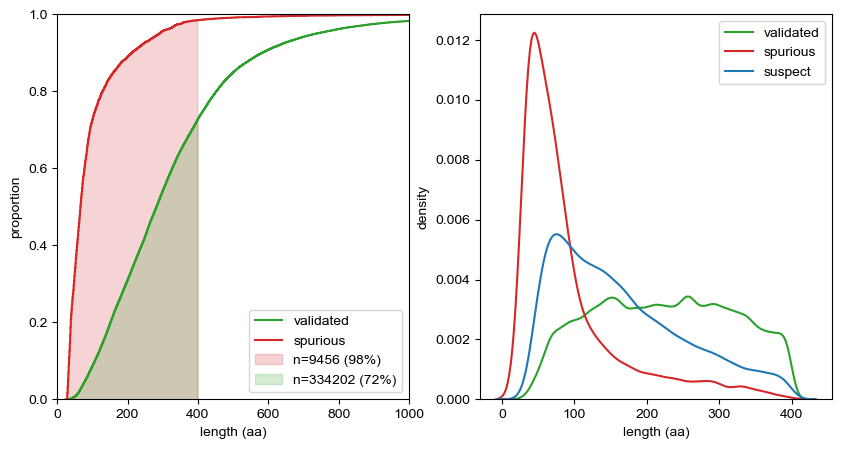

In [26]:
# The length distributions differ enough that I am a little worried that the model will take the "easy" way out and just
# learn sequence length. 
ref_out_0_df = ref_out_df[ref_out_df.ref_feature == 'CDS'].copy()
ref_out_1_df = ref_out_df[ref_out_df.ref_feature != 'CDS'].copy()

FASTAFile(df=ref_out_1_df).write('../data/spurious_protein.faa') # Write spurious sequences to a FASTA file for InterProScan.
FASTAFile(df=src.get_suspect(ref_out_0_df)).write('../data/suspect_protein.faa') # Write spurious sequences to a FASTA file for InterProScan.

dataset_df = pd.concat([ref_out_1_df.assign(label=1), ref_out_0_df.assign(label=0)], axis=0)
dataset_df = dataset_df[dataset_df.seq.apply(len) < 400] # Only look at sequences shorter than 400 amino acids. 

mmseqs = MMseqs()
dataset_df = mmseqs.cluster(dataset_df, sequence_identity=0.95, job_name='filter_dataset', reps_only=True)
train_dataset_df, test_dataset_df = train_test_split(dataset_df, test_size=0.2, train_size=0.8)
mmseqs.cleanup()

In [25]:
len(get_suspect(ref_out_0_df))

41764

remove_suspect: Removing 7382 sequences which are marked as "hypothetical protein and have only ab initio evidence."
remove_suspect: Removing 7382 sequences which are marked as "hypothetical protein and have only ab initio evidence."


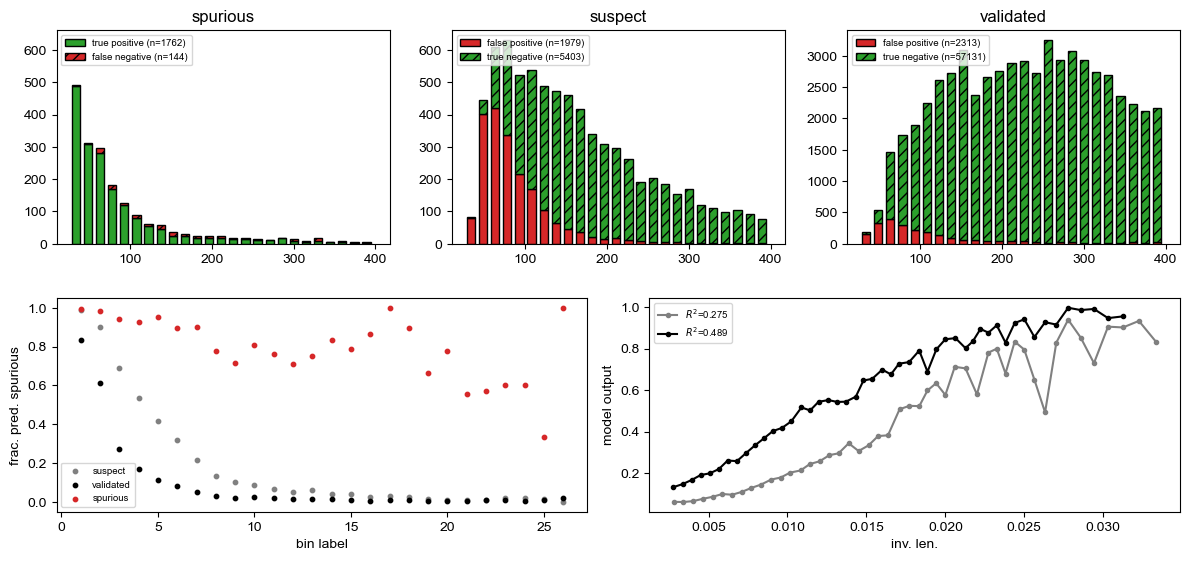

In [7]:
def figure_2(pred_out_df:pd.DataFrame, path:str=None):
    
    pred_out_df.confusion_matrix = pd.Categorical(pred_out_df.confusion_matrix, ['true positive', 'false negative', 'false positive', 'true negative'], ordered=True)
    pred_out_df['length'] = get_lengths(pred_out_df, ref=False)
    pred_out_df['inverse_length'] = 1 / pred_out_df.length
    pred_out_0_df = pred_out_df[pred_out_df.label == 0].copy() # Only look at the sequences which have a hit in the reference.
    pred_out_1_df = pred_out_df[pred_out_df.label == 1].copy() # Only look at the sequences which have a hit in the reference.

    fig = plt.figure(figsize=(12, 8), layout='tight')
    grid = GridSpec(nrows=3, ncols=6, figure=fig)

    ax_a = fig.add_subplot(grid[0, 0:2])
    ax_b = fig.add_subplot(grid[0, 2:4], sharey=ax_a)
    ax_c = fig.add_subplot(grid[0, 4:6])
    ax_d = fig.add_subplot(grid[1, 0:3])
    ax_e = fig.add_subplot(grid[1, 3:6])

    data = dict()
    data['suspect'] = get_suspect(pred_out_0_df)
    data['validated'] = remove_suspect(pred_out_0_df)
    data['spurious'] = pred_out_1_df 

    bins = 25
    for ax, label in zip([ax_a, ax_b, ax_c], ['spurious', 'suspect', 'validated']):
        df = data[label]
        lengths = [df_.length for _, df_ in df.groupby('confusion_matrix', sort=True, observed=True)]
        _, bins, _ = ax.hist(lengths, stacked=True, bins=bins, width=10, label=df.confusion_matrix.sort_values().unique())
        apply_patch_settings(ax)
        ax.legend(labels=[f'{label} (n={(df.confusion_matrix == label).sum()})' for label in df.confusion_matrix.sort_values().unique()], fontsize='x-small', loc='upper left')
        ax.set_title(label)

    ax_d_colors = {'suspect':'gray', 'validated':'black', 'spurious':'tab:red'}
    for label, df in data.items():
        df['bin_label'] = np.digitize(df.length, bins=bins)
        frac_1_per_bin = df.groupby('bin_label', sort=True).apply(lambda df : (df.model_label == 1).sum() / len(df), include_groups=False)
        ax_d.scatter(df.bin_label.sort_values().unique(), frac_1_per_bin, s=10, color=ax_d_colors[label], label=label)
    ax_d.legend(fontsize='x-small')
    ax_d.set_xlabel('bin label')
    ax_d.set_ylabel('frac. pred. spurious')

    ax_e_data = {0:remove_suspect(pred_out_0_df), 1:get_suspect(pred_out_0_df)}
    ax_e_colors = {0:'gray', 1:'black'}
    for is_suspect, df in ax_e_data.items():
        df_ = denoise(df, x_col='inverse_length', y_cols=['model_output_1'])
        x, y, x_, y_ = df.inverse_length, df.model_output_1, df_.inverse_length, df_.model_output_1
        r2, r2_ = correlation(x.values, y.values)[0], correlation(x_.values, y_.values)[0]
        # ax_e.scatter(x, y, color=ax_e_colors[is_suspect], alpha=0.2, s=3, label='$R^2$=' + str(r2))
        ax_e.plot(x_, y_, color=ax_e_colors[is_suspect], marker='o', markersize=3, label='$R^2$=' + str(r2))
    ax_e.legend(fontsize='x-small')
    ax_e.set_ylabel('model output')
    ax_e.set_xlabel('inv. len.')

    plt.show()

figure_2(pred_out_df)


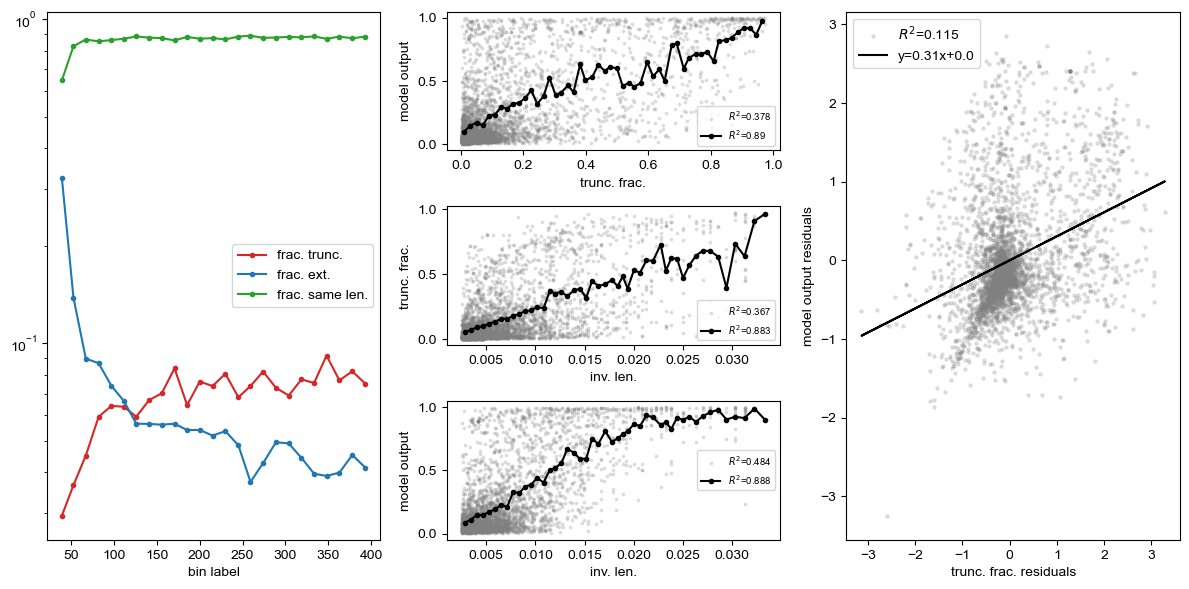

In [9]:
pred_out_0_df = pred_out_df[pred_out_df.label == 0].copy() # Get all preyydictions for sequences with a reference equivalent. 

df = pred_out_df[['model_output_1']].copy()
df['length'], df['ref_length'] = get_lengths(pred_out_0_df, ref=False), get_lengths(pred_out_0_df, ref=True)
df['length_diff'] = df.ref_length - df.length
df['inverse_length'] = 1 / df.length
df['trunc_size'] = np.where(df.length_diff > 0, df.length_diff, 0) 
df['trunc_frac'] = df.trunc_size / df.ref_length 

bin_labels, bin_edges = pd.cut(df.length, bins=25, retbins=True, labels=False)
df['bin_label'] = bin_labels

fig = plt.figure(layout='tight', figsize=(12, 6))
grid = GridSpec(nrows=3, ncols=3, figure=fig)

ax_a = fig.add_subplot(grid[:, 0])
ax_b = [fig.add_subplot(grid[i, 1]) for i in range(3)]
ax_c = fig.add_subplot(grid[:, 2]) 

lengths =  df.groupby('bin_label').length.mean() # Get the mean sequence length per bin. 
ax_a_data = dict()
ax_a_data['frac. trunc.'] = df.groupby('bin_label').apply(lambda df : (df.length_diff < 0).sum() / len(df), include_groups=False)
ax_a_data['frac. ext.'] = df.groupby('bin_label').apply(lambda df : (df.length_diff > 0).sum() / len(df), include_groups=False)
ax_a_data['frac. same len.'] = df.groupby('bin_label').apply(lambda df : (df.length_diff == 0).sum() / len(df), include_groups=False)
ax_a_colors = {'frac. trunc.':'tab:red', 'frac. ext.':'tab:blue', 'frac. same len.':'tab:green'}

for label, data in ax_a_data.items():
    ax_a.plot(lengths, data, label=label, color=ax_a_colors[label], marker='o', markersize=3)

ax_a.set_yscale('log')
ax_a.set_xlabel('log(frac.)')
ax_a.set_xlabel('bin label')
ax_a.legend()

df = df[df.trunc_size > 0]

# xy_cols = [('trunc_frac', 'model_output_1'), ('length', 'trunc_frac'), ('length', 'model_output_1')]
xy_cols = [('trunc_frac', 'model_output_1'), ('inverse_length', 'trunc_frac'), ('inverse_length', 'model_output_1')]
labels = {'trunc_frac':'trunc. frac.', 'model_output_1':'model output', 'inverse_length':'inv. len.'}

for (x_col, y_col), ax in zip(xy_cols, ax_b): 
    df_ = denoise(df, x_col=x_col, y_cols=[y_col])

    r2, _ = correlation(df[x_col].values, df[y_col].values)
    r2_, _ = correlation(df_[x_col].values, df_[y_col].values)

    ax.scatter(df[x_col], df[y_col], color='gray', alpha=0.2, s=3, label='$R^2$=' + str(r2))
    ax.plot(df_[x_col], df_[y_col], color='black', marker='o', markersize=3, label='$R^2$=' + str(r2_))
    ax.legend(fontsize='x-small')
    ax.set_xlabel(labels[x_col])
    ax.set_ylabel(labels[y_col])

x, y, z = df.trunc_frac.values, df.model_output_1.values, df.inverse_length.values
r2, linreg, (x_residuals, y_residuals) = partial_correlation(x, y, z)
ax_c.scatter(x_residuals, y_residuals, color='gray', label='$R^2$=' + str(r2), s=5, alpha=0.2)

m, b = np.round(linreg.coef_, 2).item(), np.round(linreg.intercept_, 2)
ax_c.plot(x_residuals, linreg.predict(x_residuals.reshape(-1, 1)), color='black', label=f'y={m}x+{b}')
ax_c.set_xlabel('trunc. frac. residuals')
ax_c.set_ylabel('model output residuals')
ax_c.legend()
plt.show()



In [13]:
# # First thing I want to look at is the accuracy per genome. 
# fig, axes = plt.subplots(ncols=2, layout='tight', figsize=(8, 4))

# ax = axes[0]
# accs = pred_out_df.groupby('genome_id').apply(lambda df : balanced_accuracy_score(df.label, df.model_label), include_groups=False)
# ax.hist(accs, bins=20, color='gray', width=0.01, edgecolor='black')
# ax.set_xlabel('balanced accuracy')
# ax.set_ylabel('count')

# ax = axes[1]
# labels = ['correct', 'spurious']
# matrix = confusion_matrix(pred_out_df.label.values, pred_out_df.model_label.values) #, labels=sorted(pred_out_df.label.unique()))
# matrix = pd.DataFrame(matrix, columns=labels, index=labels)
# matrix = matrix.apply(lambda x: x/x.sum(), axis=0) # Normalize the matrix.

# sns.heatmap(matrix, ax=ax, annot=True, cbar=False, linecolor='black', lw=0.2, fmt='.1%', cmap='Blues') # fmt='.1%',

# # Rotate the tick labels on the x-axis of each subplot.
# ax.set_xticks(np.arange(len(labels)) + 0.5, matrix.columns, rotation=45, ha='right')
# ax.set_yticks(np.arange(len(labels)) + 0.5, matrix.columns, rotation=0)
# ax.set_xlabel('predicted label')
# ax.set_ylabel('true label')

# plt.show()

# The UserWarning from scikitlearn is because some of the genomes have no Prodigal false positives in the testing set. 

def table_2(pred_out_df:pd.DataFrame, path:str='../figures/filter-table_1.png'):
    table_df = dict()

    table_df['accuracy'] = pred_out_df.groupby('genome_id').apply(lambda df : balanced_accuracy_score(df.label, df.model_label) , include_groups=False)
    
    for confusion_matrix, df in pred_out_df.groupby('confusion_matrix'):
        table_df[confusion_matrix] = df.groupby('genome_id').apply(len, include_groups=False)
    table_df = pd.DataFrame(table_df)
    
    table_df = table_df.sort_values('false positive')
    dfi.export(table_df.iloc[:50], path)
    return table_df


table_2(pred_out_df)

/home/prichter/miniconda3/envs/tripy/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/prichter/miniconda3/envs/tripy/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/prichter/miniconda3/envs/tripy/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/tmp/ipykernel_2315073/1604718123.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for confusion_matrix, df in pred_out_df.groupby('confusion_matrix'):
122764 

,accuracy,true positive,false negative,false positive,true negative
genome_id,,,,,
GCF_001641825.1,0.993311,NaN,NaN,2,297
GCF_002688585.1,0.492147,NaN,1.0,3,188
GCF_005080965.1,0.980000,1.0,NaN,3,72
GCF_000020945.1,0.975962,NaN,NaN,5,203
GCF_002252155.1,0.821970,2.0,1.0,6,258
...,...,...,...,...,...
GCF_000445445.1,0.946174,29.0,NaN,83,688
GCF_900129935.1,0.897651,20.0,2.0,85,662
GCF_014698845.1,0.939917,35.0,NaN,87,637


/home/prichter/Documents/tripy/notebooks/utils.py:45: UserWarning: check_cds: Not all entries in the input DataFrame correspond to CDS features. Found: CDS, nan, rRNA, tRNA, ncRNA, misc_feature, misc_RNA
  warnings.warn(f'check_cds: Not all entries in the input DataFrame correspond to CDS features. Found: {features}')
/home/prichter/Documents/tripy/notebooks/utils.py:45: UserWarning: check_cds: Not all entries in the input DataFrame correspond to CDS features. Found: CDS, misc_RNA, misc_feature, ncRNA, rRNA
  warnings.warn(f'check_cds: Not all entries in the input DataFrame correspond to CDS features. Found: {features}')
/home/prichter/Documents/tripy/notebooks/utils.py:45: UserWarning: check_cds: Not all entries in the input DataFrame correspond to CDS features. Found: CDS, misc_feature, misc_RNA, rRNA, tRNA
  warnings.warn(f'check_cds: Not all entries in the input DataFrame correspond to CDS features. Found: {features}')


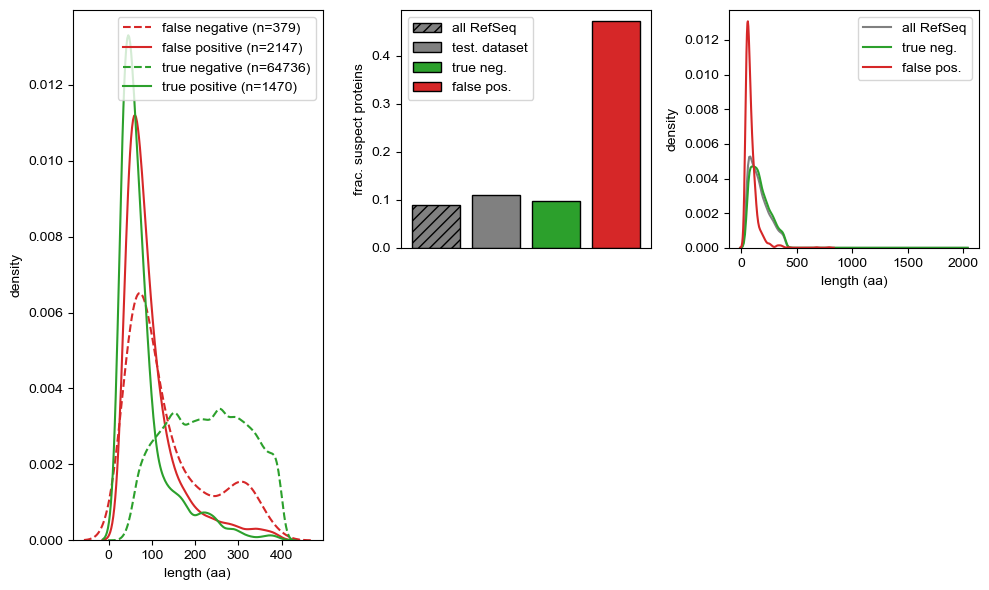

In [146]:
# I am mainly worried about the things that the model has predicted to be wrong, but are actually correct. 
# It does seem to have mainly just learned length. 
def figure_3(pred_out_df:pd.DataFrame, ref_out_df:pd.DataFrame, path:str=None, model_name:str='filter_balance_classes_and_lengths'):

    fig = plt.figure(layout='tight', figsize=(10, 6))
    grid = GridSpec(nrows=2, ncols=3, figure=fig)

    ax_a = fig.add_subplot(grid[:, 0])
    ax_b = fig.add_subplot(grid[0, 1])
    ax_c = fig.add_subplot(grid[0, 2])

    labels = []
    for confusion_matrix, df in pred_out_df.groupby('confusion_matrix'):
        sns.kdeplot(df.seq.apply(len), label=confusion_matrix, ax=ax_a)
        labels.append(f'{confusion_matrix} (n={len(df)})')
    apply_line_settings(ax_a)
    ax_a.legend(labels=labels)
    ax_a.set_ylabel('density')
    ax_a.set_xlabel('length (aa)')
    
    labels = ['all RefSeq', 'test. dataset', 'true neg.', 'false pos.']
    positions = np.arange(len(labels))
    heights = list()
    heights += [get_frac_suspect(ref_out_df)]
    heights += [get_frac_suspect(pred_out_df[pred_out_df.ref_feature == 'CDS'])]
    heights += [get_frac_suspect(pred_out_df[pred_out_df.confusion_matrix == 'true negative'])]
    heights += [get_frac_suspect(pred_out_df[pred_out_df.confusion_matrix == 'false positive'])]
    ax_b.bar(positions, heights, label=labels, color=['gray', 'gray', 'tab:green', 'tab:red'], edgecolor='black', hatch=['///', None, None, None])
    ax_b.set_ylabel('frac. suspect proteins')
    ax_b.set_xticks([])
    ax_b.legend()

    sns.kdeplot(get_lengths(get_suspect(pred_out_df)), color='gray', ax=ax_c, label='all RefSeq')
    sns.kdeplot(get_lengths(get_suspect(pred_out_df[pred_out_df.confusion_matrix == 'true negative'])), color='tab:green', ax=ax_c, label='true neg.')
    sns.kdeplot(get_lengths(get_suspect(pred_out_df[pred_out_df.confusion_matrix == 'false positive'])), color='tab:red', ax=ax_c, label='false pos.')
    ax_c.legend()
    ax_c.set_ylabel('density')
    ax_c.set_xlabel('length (aa)')
    plt.show()


figure_3(pred_out_df, ref_out_df)
    # Does this have something to do with the truncation sizes of the false positives versus true positives, or is it really just length?

    # for confusion_matrix in ['false positive', 'true negative']:
    #     df = pred_out_df[pred_out_df.confusion_matrix == confusion_matrix]
    #     diffs = [((row.ref_stop - row.ref_start) - (row.stop - row.stop)) // 3 for row in df.itertuples()]
    #     ref_lengths = [(row.ref_stop - row.ref_start) // 3 for row in df.itertuples()] 
    #     lengths = [(row.stop - row.start) // 3 for row in df.itertuples()] 
    #     ax.scatter(lengths, df.filter_balance_classes_and_lengths_output_1,  s=5, **kwargs[confusion_matrix])
    # ax.set_xscale('log')

AttributeError: 'DataFrame' object has no attribute 'filter_balance_classes_and_lengths_label'

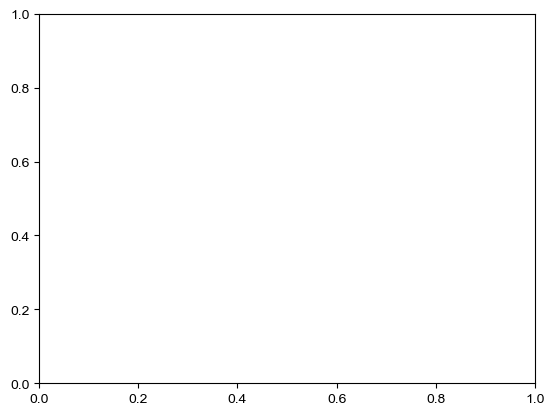

In [147]:
# Not sure if the problem is length or the fact that the reference proteins aren't real... 
# How reliable are the labels? Should I discard the suspect proteins from the positive testing set?

fig, ax = plt.subplots()

pred_out_1_df = pred_out_df[pred_out_df.filter_balance_classes_and_lengths_label == 1]


In [ ]:
pred_out_df[pred_out_df.confusion_matrix == 'false positive'].ref_product.value_counts()
pred_out_df[pred_out_df.confusion_matrix == 'true negative'].ref_product.value_counts()

pred_out_fp_df = pred_out_df[pred_out_df.confusion_matrix == 'false positive']
pred_out_tn_df = pred_out_df[pred_out_df.confusion_matrix == 'true negative']

pred_out_df[(pred_out_df.ref_product == 'hypothetical protein') & pred_out_df.ref_seq.isnull()][['ref_pseudo', 'ref_product', 'partial', 'ref_evidence_type', 'ref_partial']]
pred_out_fp_df[(pred_out_fp_df.ref_product == 'hypothetical protein')].value_counts('ref_evidence_type')
pred_out_tn_df[(pred_out_tn_df.ref_product == 'hypothetical protein')].value_counts('ref_evidence_type')

ref_evidence_type
ab initio prediction      6368
similar to AA sequence    3647
protein motif              202
profile                     14
Name: count, dtype: int64

In [ ]:
get_ab_initio(pred_out_df).ref_product.value_counts() / len(get_ab_initio(pred_out_df))

ref_product
hypothetical protein                                            0.889170
helix-turn-helix domain-containing protein                      0.001927
putative integral inner membrane protein                        0.001325
conserved protein of unknown function; phage SPbeta             0.001084
alpha/beta hydrolase                                            0.001084
                                                                  ...   
PseG/SpsG family protein                                        0.000120
putative efflux transporter; prophage 1 region                  0.000120
ubiquitin carboxyl-terminal hydrolase family protein            0.000120
putative glycosyltransferase (complex carbohydrate synthase)    0.000120
efflux RND transporter periplasmic adaptor subunit              0.000120
Name: count, Length: 645, dtype: float64

In [ ]:
# What is the length distribution of hypothetical proteins versus Prodigal errors?

In [ ]:
train_df = pd.read_csv('../data/filter_dataset_train.csv', index_col=0)
test_df = pd.read_csv('../data/filter_dataset_test.csv', index_col=0)

x_train, y_train = train_df.seq.apply(len).values, train_df.label.values
x_test, y_test = test_df.seq.apply(len).values, test_df.label.values

model = LogisticRegression(class_weight='balanced', C=0.001, tol=1e-8)
model.fit(x_train.reshape(-1, 1), y_train)

y_test_pred = model.predict(x_test.reshape(-1, 1))
y_train_pred = model.predict(x_train.reshape(-1, 1))

print('Balanced test accuracy:', balanced_accuracy_score(y_test, y_test_pred.ravel()))
print('Balanced train accuracy:', balanced_accuracy_score(y_train, y_train_pred.ravel()))

Balanced test accuracy: 0.7958396559282479
Balanced train accuracy: 0.7948956639028347


In [56]:
model.n_iter_

array([18], dtype=int32)